In [1]:
'''
Date: 2023/Jan/1
Author: Yike Xie
Content: Create the fluorescent matrix of FAD according to existing publications
'''

'\nDate: 2022/Dec/22\nAuthor: Yike Xie\nContent: Create the fluorescent matrix of NADP according to existing publications\n'

In [2]:
# paper: http://www.columbia.edu/cu/chemistry/groups/nakanishi/publication/702-Fluorescent%20Pigments%20of%20the%20Retinal%20Pigment%20Epithelium%20and%20Age-Related%20Macular%20Degeneration.pdf

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns

In [60]:
wls =np.array([
 (325, 414),
 (343, 414),#
 (370, 414),
 (343, 451),
 (370, 451),
 (373, 451),
 (343, 575),#
 (393, 575),
 (406, 575),
 (441, 575),
 (400, 594),
 (406, 594),
 (431, 594),
 (480, 594),#
 (339, 575),
])

In [34]:
def load_figure(fmt_fn, fmt_fn1):
    rgba_image = PIL.Image.open(fmt_fn)
    rgb_image = rgba_image.convert('RGB')
    rgb_image.save(fmt_fn1)

    # load as a RGB image
    fmt = plt.imread(fmt_fn1)
    fmt *= 255
    fmt = fmt.astype(int)

    plt.imshow(fmt)
    plt.axis('off')
    
    return fmt

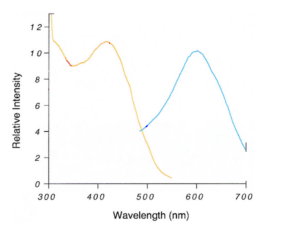

In [36]:
fmt_fn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/A2E2.png'
fmt_fn1 = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/A2E3.png'
fmt_ems = load_figure(fmt_fn, fmt_fn1)

In [53]:
def get_array(fmt):
    w = fmt.shape[1]
    l = fmt.shape[0]
    
    R = ((fmt[:, :, 0] > 230) & (fmt[:, :, 0] < 240) &
         (fmt[:, :, 1] < 125) & (fmt[:, :, 1] > 90) & 
         (fmt[:, :, 2] > 110) & (fmt[:, :, 2] < 140)) # red
    O = ((fmt[:, :, 0] > 220) & 
         (fmt[:, :, 1] > 190) & (fmt[:, :, 1] < 230) & 
         (fmt[:, :, 2] > 155) & (fmt[:, :, 2] < 185)) # orange
    B = ((fmt[:, :, 0] > 90) & (fmt[:, :, 0] < 120) & 
         (fmt[:, :, 1] > 180) & (fmt[:, :, 1] < 210) & 
         (fmt[:, :, 2] > 225)) # blue
    K = ((fmt[:, :, 0] < 50) & (fmt[:, :, 1] < 50) & (fmt[:, :, 2] <50))

    # center
    cx = pd.Series(fmt[:, :, :].sum(axis=2).sum(axis=0), index=range(w)).sort_values().index[0] # x axis 70
    cy = pd.Series(fmt[:, :, :].sum(axis=2).sum(axis=1), index=range(l)).sort_values().index[0] # y axis 214

    # x axis, max
    x = pd.Series(fmt[:, :, :].sum(axis=2)[cy, :], index=range(w))
    # xmin = x[x < 100].index[0]
    xmax = x[x < 150].index[-1]

    # y axis, min
    y = pd.Series(fmt[:, :, :].sum(axis=2)[:, cx], index=range(l))
    ymin = y[y < 150].index[0]  # upper
    # ymax = y[y < 100].index[-1] # lower
    
    fig, axs = plt.subplots(3, 2, figsize=[10, 9])
    axs[0, 0].imshow(R)
    axs[0, 1].imshow(O)
    axs[1, 0].imshow(B) 
    axs[1, 1].imshow(K)
    axs[2, 0].imshow(K)

    axs[2, 0].imshow(K)
    axs[2, 0].scatter(cx, cy, c='red', s=10)
    axs[2, 0].scatter(cx, ymin, c='red', s=10)
    axs[2, 0].scatter(xmax, cy, c='red', s=10)
    
    axs[2, 1].imshow(fmt)
    
    return {'R': R, 'O': O, 'B': B, 'K': K, 'cx': cx, 'xmax': xmax, 'cy': cy, 'ymin': ymin}

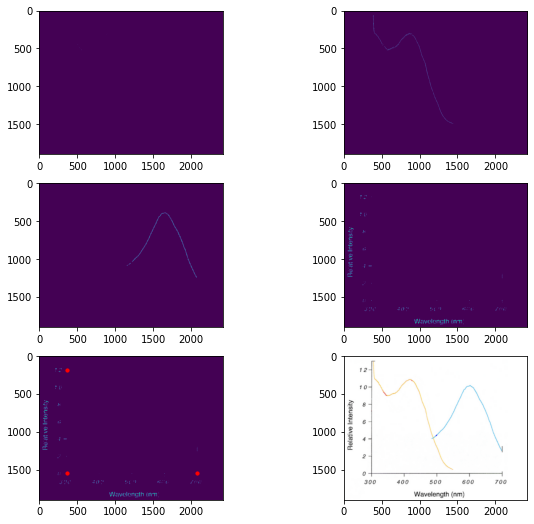

In [54]:
ems_dic = get_array(fmt_ems)

In [72]:
def get_ratio(ems_dic, C, imin, imax, wmin, wmax):
    C, K, cx, xmax, cy, ymin= ems_dic[C], ems_dic['K'], ems_dic['cx'], ems_dic['xmax'], ems_dic['cy'], ems_dic['ymin']
    ems = np.argwhere(C) # [y, x] [:, 1] x, [:, 0] y
    
    # emission wavelengths and fluorescent intensity
    em_its = {(x - cx) * (wmax - wmin) / (xmax - cx) + wmin : (imax - imin) * (cy - y) / (cy - ymin) + imin 
              for y, x  in ems}
    
    fig, axs = plt.subplots(2, figsize=(4, 3))
    axs[0].imshow(K)
    axs[0].scatter(ems[:, 1], ems[:, 0], color='red', s=5)

    axs[1].set_xlim(wmin, wmax)
    axs[1].set_ylim(imin, imax)
    axs[1].scatter(em_its.keys(), em_its.values(), color='red', s=5)
    axs[1].set_xlabel('Wavelengths (nm)')
    axs[1].set_ylabel('Fluorescent intensity')
    
    # emission wavelengths and fluorescent ratio
    em_it_max = max(em_its.values())
    import math
    em_ratio = {round(k, 1): v / em_it_max for k, v in em_its.items()}
    
    return em_ratio

def matrix(ex_ratio, em_ratio, name):
    # create the matrix and plot
    columns = list(ex_ratio.keys())
    columns.sort()
    index = list(em_ratio.keys())
    index.sort()
    index = index[::-1]

    df = pd.DataFrame(np.zeros(shape=(len(index), len(columns))), 
                          index=index, columns=columns)

    for x in ex_ratio.keys():
        for y in em_ratio.keys():
            df.at[y, x] = ex_ratio[x] * em_ratio[y]
    
    fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/heatmap/'
    df.to_csv(fdn + name + '_FL_ratio_matrix.tsv', sep='\t')

    fig, ax = plt.subplots()
    sns.heatmap(df, cmap='viridis', ax=ax)
    ax.set_xlabel('Excitation Wavelength (nm)')
    ax.set_ylabel('Emission Wavelength (nm)')
    ax.set_title(name)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xmin, xmax = df.columns.min(), df.columns.max()
    ymin, ymax = df.index.min(), df.index.max()
    sx = [(i - xmin) * (xlim[1] - xlim[0]) / (xmax - xmin) + xlim[0] for i in wls[:, 0].tolist()]
    sy = [(i - ymin) * (ylim[1] - ylim[0]) / (ymax - ymin) + ylim[0] for i in wls[:, 1].tolist()]
    
    colors = sns.color_palette('hls', 15)
    handles, labels = ax.get_legend_handles_labels()
    for i, txt in enumerate(range(1, 16)):
        ax.scatter(sx[i], sy[i], color=colors[i], s=50)
        handles.append(ax.scatter([], [], color=colors[i], s=50)) 

    ax.legend(handles=handles, labels = [str(i) for i in wls], bbox_to_anchor=(1.55, 1.05))
    plt.savefig(fdn + name + '.png', dpi=300, bbox_inches='tight')
    
    return df

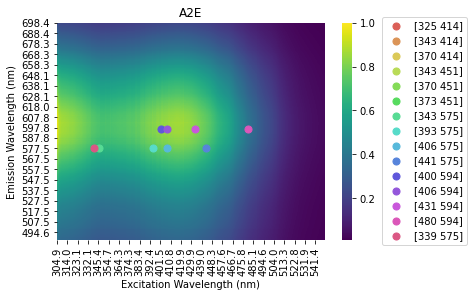

In [73]:
name = 'A2E'
ex_ratio = get_ratio(ems_dic, 'O', 0, 13, 300, 700)
em_ratio = get_ratio(ems_dic, 'B', 0, 13, 300, 700)
df = matrix(ex_ratio, em_ratio, name)

In [69]:
df

,304.9,305.1,305.4,305.6,305.8,306.1,306.3,306.5,306.8,307.0,...,547.7,548.0,548.2,548.4,548.7,548.9,549.4,549.6,549.8,550.1
698.4,0.258621,0.257534,0.250290,0.245943,0.245219,0.239423,0.237431,0.234352,0.232360,0.231092,...,0.008874,0.008874,0.008693,0.008693,0.008693,0.008693,0.008874,0.008874,0.009055,0.009055
698.1,0.258621,0.257534,0.250290,0.245943,0.245219,0.239423,0.237431,0.234352,0.232360,0.231092,...,0.008874,0.008874,0.008693,0.008693,0.008693,0.008693,0.008874,0.008874,0.009055,0.009055
697.9,0.258621,0.257534,0.250290,0.245943,0.245219,0.239423,0.237431,0.234352,0.232360,0.231092,...,0.008874,0.008874,0.008693,0.008693,0.008693,0.008693,0.008874,0.008874,0.009055,0.009055
697.7,0.260345,0.259251,0.251958,0.247583,0.246854,0.241020,0.239014,0.235915,0.233909,0.232633,...,0.008933,0.008933,0.008751,0.008751,0.008751,0.008751,0.008933,0.008933,0.009116,0.009116
697.4,0.262069,0.260968,0.253627,0.249222,0.248488,0.242616,0.240597,0.237477,0.235458,0.234174,...,0.008993,0.008993,0.008809,0.008809,0.008809,0.008809,0.008993,0.008993,0.009176,0.009176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485.6,0.399138,0.397461,0.386281,0.379572,0.378454,0.369510,0.366435,0.361684,0.358609,0.356653,...,0.013696,0.013696,0.013416,0.013416,0.013416,0.013416,0.013696,0.013696,0.013975,0.013975
485.3,0.398276,0.396602,0.385446,0.378753,0.377637,0.368712,0.365644,0.360903,0.357835,0.355882,...,0.013666,0.013666,0.013387,0.013387,0.013387,0.013387,0.013666,0.013666,0.013945,0.013945
485.1,0.395690,0.394027,0.382943,0.376293,0.375185,0.366318,0.363270,0.358559,0.355511,0.353571,...,0.013578,0.013578,0.013300,0.013300,0.013300,0.013300,0.013578,0.013578,0.013855,0.013855
484.9,0.394828,0.393169,0.382109,0.375473,0.374367,0.365520,0.362478,0.357778,0.354737,0.352801,...,0.013548,0.013548,0.013272,0.013272,0.013272,0.013272,0.013548,0.013548,0.013824,0.013824
